# Programming Exercise 4:  Neural Networks Learning

## Introduction

In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.


All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. The assignment can be promptly submitted to the coursera grader directly from this notebook (code and instructions are included below).

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools. You can find instructions on how to install required libraries in the README file in the [github repository](https://github.com/dibgerge/ml-coursera-python-assignments).

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# define the submission/grader object for this exercise
grader = utils.Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## Submission and Grading


After completing each part of the assignment, be sure to submit your solutions to the grader. The following is a breakdown of how each part of this exercise is scored.


| Section | Part                                             | Submission function | Points 
| :-      |:-                                                | :-                  | :-:    
| 1       | [Feedforward and Cost Function](#section1)                    | [`nnCostFunction`](#nnCostFunction)   | 30     
| 2       | [Regularized Cost Function](#section2)                        | [`nnCostFunction`](#nnCostFunction)   | 15     
| 3       | [Sigmoid Gradient](#section3)                                 | [`sigmoidGradient`](#sigmoidGradient) | 5      
| 4       | [Neural Net Gradient Function (Backpropagation)](#section4)   | [`nnCostFunction`](#nnCostFunction)   | 40     
| 5       | [Regularized Gradient](#section5)                             | [`nnCostFunction`](#nnCostFunction)   |10     
|         | Total Points                                     |    | 100    


You are allowed to submit your solutions multiple times, and we will take only the highest score into consideration.

<div class="alert alert-block alert-warning">
At the end of each section in this notebook, we have a cell which contains code for submitting the solutions thus far to the grader. Execute the cell to see your score up to the current section. For all your work to be submitted properly, you must execute those cells at least once.
</div>

## Neural Networks

In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.

We start the exercise by first loading the dataset. 

In [2]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex4data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# Number of training examples
m = y.size

### 1.1 Visualizing the data

You will begin by visualizing a subset of the training set, using the function `displayData`, which is the same function we used in Exercise 3. It is provided in the `utils.py` file for this assignment as well. The dataset is also the same one you used in the previous exercise.

There are 5000 training examples in `ex4data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each
of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \left(x^{(1)} \right)^T - \\
- \left(x^{(2)} \right)^T - \\
\vdots \\
- \left(x^{(m)} \right)^T - \\
\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set. 
The following cell randomly selects 100 images from the dataset and plots them.

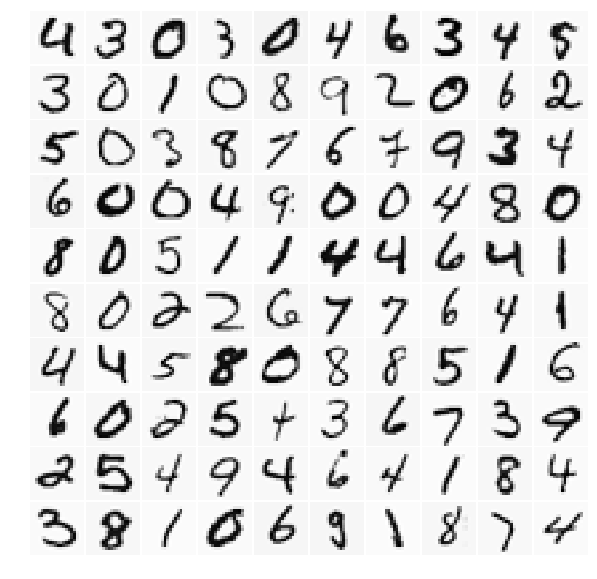

In [3]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

### 1.2 Model representation

Our neural network is shown in the following figure.

![](Figures/neural_network.png)

It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values
of digit images. Since the images are of size $20 \times 20$, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data was loaded into the variables `X` and `y` above.

You have been provided with a set of network parameters ($\Theta^{(1)}, \Theta^{(2)}$) already trained by us. These are stored in `ex4weights.mat` and will be loaded in the next cell of this notebook into `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [4]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the weights into variables Theta1 and Theta2
weights = loadmat(os.path.join('Data', 'ex4weights.mat'))

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

<a id="section1"></a>
### 1.3 Feedforward and cost function

Now you will implement the cost function and gradient for the neural network. First, complete the code for the function `nnCostFunction` in the next cell to return the cost.

Recall that the cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_\theta \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output
value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to encode the labels as vectors containing only values 0 or 1, so that

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. **Your code should also work for a dataset of any size, with any number of labels** (you can assume that there are always at least $K \ge 3$ labels).

<div class="alert alert-box alert-warning">
**Implementation Note:** The matrix $X$ contains the examples in rows (i.e., X[i,:] is the i-th training example $x^{(i)}$, expressed as a $n \times 1$ vector.) When you complete the code in `nnCostFunction`, you will need to add the column of 1’s to the X matrix. The parameters for each unit in the neural network is represented in Theta1 and Theta2 as one row. Specifically, the first row of Theta1 corresponds to the first hidden unit in the second layer. You can use a for-loop over the examples to compute the cost.
</div>
<a id="nnCostFunction"></a>

In [5]:
# On définit la fonction sigmoid
import math
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [97]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size : int
        Number of features for the input layer. 
    
    hidden_layer_size : int
        Number of hidden units in the second layer.
    
    num_labels : int
        Total number of labels, or equivalently number of units in output layer. 
    
    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).
    
    y : array_like
        Dataset labels. A vector of shape (m,).
    
    lambda_ : float, optional
        Regularization parameter.
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    
    Instructions
    ------------
    You should complete the code by working through the following parts.
    
    - Part 1: Feedforward the neural network and return the cost in the 
              variable J. After implementing Part 1, you can verify that your
              cost function computation is correct by verifying the cost
              computed in the following cell.
    
    - Part 2: Implement the backpropagation algorithm to compute the gradients
              Theta1_grad and Theta2_grad. You should return the partial derivatives of
              the cost function with respect to Theta1 and Theta2 in Theta1_grad and
              Theta2_grad, respectively. After implementing Part 2, you can check
              that your implementation is correct by running checkNNGradients provided
              in the utils.py module.
    
              Note: The vector y passed into the function is a vector of labels
                    containing values from 0..K-1. You need to map this vector into a 
                    binary vector of 1's and 0's to be used with the neural network
                    cost function.
     
              Hint: We recommend implementing backpropagation using a for-loop
                    over the training examples if you are implementing it for the 
                    first time.
    
    - Part 3: Implement regularization with the cost function and gradients.
    
              Hint: You can implement this around the code for
                    backpropagation. That is, you can compute the gradients for
                    the regularization separately and then add them to Theta1_grad
                    and Theta2_grad from Part 2.
    
    Note 
    ----
    We have provided an implementation for the sigmoid function in the file 
    `utils.py` accompanying this assignment.
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    # ====================== YOUR CODE HERE ======================
    
    
    #print("X :", X.shape)
    #print("y :", y.shape, "\n", y)
    #print("Theta1 :", Theta1.shape)
    #print("Theta2 :", Theta2.shape)
    
    comparaison = np.arange(num_labels)
    comparaison = np.tile(comparaison, (m,1))
    y_encoded_binary = np.equal(comparaison, np.tile(y, (num_labels,1)).T, dtype=int).astype(int)
    #print("y_encoded_binary :", y_encoded_binary.shape)

    a1 = np.insert(X, 0, 1, axis=1)
    #print(a1)
    
    z2 = np.dot(a1, Theta1.T)    
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, 1, axis=1)
    
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)
    #print("a3 :", a3.shape)
    
    J1 = -y_encoded_binary * np.log(a3)
    #print(J1)
    
    J2 = -(1-y_encoded_binary) * np.log( 1-a3 )
    
    #We get the unregularized cost
    J = 1/m * np.sum(J1+J2)
    
    #Let's add regularization to the cost function
    
    #print(Theta1[:,1:]**2)
    J += lambda_/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2) )
    
    print("Loss J = ", J)
    
    # We do backpropagation
    
    #print("m :", m)
    for t in range(m):
        #print("Data n° " + str(t))
        # step 1
        a1 = X[t]
        #print(a1.shape)
        a1 = np.insert(a1, 0, 1, axis=0)
        #print(a1.shape)
        z2 = np.dot(a1, Theta1.T)
        a2 = sigmoid(z2)
        a2 = np.insert(a2, 0, 1, axis=0)
        z3 = np.dot(a2, Theta2.T)
        a3 = sigmoid(z3)
        #print("a3: ", a3.shape)
        
        # step 2
        #delta_3 = np.zeros(a3.shape)
        #print("delta-3", delta_3.shape)
        delta_3 = a3 - y_encoded_binary[t]
        
        # step 3
        #print(Theta2.T.shape, delta_3.shape, sigmoidGradient(z2).shape)
        delta_2 = np.dot(Theta2.T, delta_3) * (a2*(1-a2))
        
        # step 4
        delta_2 = delta_2[1:]
        # no delta_1 because no error term for the input layer
        
        Theta2_grad = Theta2_grad + delta_3[:,np.newaxis]*a2[np.newaxis,:]
        Theta1_grad = Theta1_grad + delta_2[:,np.newaxis]*a1[np.newaxis,:]
        
    # step 5
    #print("blabla",Theta2_grad.shape, delta_3.shape, a2.T.shape)
    Theta2_grad /= m
    Theta1_grad /= m
    
    #print("Theta2 :", Theta2)
    #print(np.insert(Theta2[:,1:], 0, 0, axis=1))
    
    p2 = (lambda_/m) * np.insert(Theta2[:,1:], 0, 0, axis=1)
    p1 = (lambda_/m) * np.insert(Theta1[:,1:], 0, 0, axis=1)
    
    Theta2_grad += p2
    Theta1_grad += p1
   
    # ================================================================
    # Unroll gradients
    # grad = np.concatenate([Theta1_grad.ravel(order=order), Theta2_grad.ravel(order=order)])
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, grad

<div class="alert alert-box alert-warning">
Use the following links to go back to the different parts of this exercise that require to modify the function `nnCostFunction`.<br>

Back to:
- [Feedforward and cost function](#section1)
- [Regularized cost](#section2)
- [Neural Network Gradient (Backpropagation)](#section4)
- [Regularized Gradient](#section5)
</div>

Once you are done, call your `nnCostFunction` using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the cost is about 0.287629.

In [67]:
lambda_ = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f ' % J)
print('The cost should be about                   : 0.287629.')

X : (5000, 400)
y : (5000,) 
 [0 0 0 ..., 9 9 9]
Theta1 : (25, 401)
Theta2 : (10, 26)
y_encoded_binary : (5000, 10)
a3 : (5000, 10)
m : 5000
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
Data n° 5
Data n° 6
Data n° 7
Data n° 8
Data n° 9
Data n° 10
Data n° 11
Data n° 12
Data n° 13
Data n° 14
Data n° 15
Data n° 16
Data n° 17
Data n° 18
Data n° 19
Data n° 20
Data n° 21
Data n° 22
Data n° 23
Data n° 24
Data n° 25
Data n° 26
Data n° 27
Data n° 28
Data n° 29
Data n° 30
Data n° 31
Data n° 32
Data n° 33
Data n° 34
Data n° 35
Data n° 36
Data n° 37
Data n° 38
Data n° 39
Data n° 40
Data n° 41
Data n° 42
Data n° 43
Data n° 44
Data n° 45
Data n° 46
Data n° 47
Data n° 48
Data n° 49
Data n° 50
Data n° 51
Data n° 52
Data n° 53
Data n° 54
Data n° 55
Data n° 56
Data n° 57
Data n° 58
Data n° 59
Data n° 60
Data n° 61
Data n° 62
Data n° 63
Data n° 64
Data n° 65
Data n° 66
Data n° 67
Data n° 68
Data n° 69
Data n° 70
Data n° 71
Data n° 72
Data n° 73
Data n° 74
Data n° 75
Data n° 76
Data n° 77
Data n° 78


Data n° 768
Data n° 769
Data n° 770
Data n° 771
Data n° 772
Data n° 773
Data n° 774
Data n° 775
Data n° 776
Data n° 777
Data n° 778
Data n° 779
Data n° 780
Data n° 781
Data n° 782
Data n° 783
Data n° 784
Data n° 785
Data n° 786
Data n° 787
Data n° 788
Data n° 789
Data n° 790
Data n° 791
Data n° 792
Data n° 793
Data n° 794
Data n° 795
Data n° 796
Data n° 797
Data n° 798
Data n° 799
Data n° 800
Data n° 801
Data n° 802
Data n° 803
Data n° 804
Data n° 805
Data n° 806
Data n° 807
Data n° 808
Data n° 809
Data n° 810
Data n° 811
Data n° 812
Data n° 813
Data n° 814
Data n° 815
Data n° 816
Data n° 817
Data n° 818
Data n° 819
Data n° 820
Data n° 821
Data n° 822
Data n° 823
Data n° 824
Data n° 825
Data n° 826
Data n° 827
Data n° 828
Data n° 829
Data n° 830
Data n° 831
Data n° 832
Data n° 833
Data n° 834
Data n° 835
Data n° 836
Data n° 837
Data n° 838
Data n° 839
Data n° 840
Data n° 841
Data n° 842
Data n° 843
Data n° 844
Data n° 845
Data n° 846
Data n° 847
Data n° 848
Data n° 849
Data n° 850
Data

Data n° 1680
Data n° 1681
Data n° 1682
Data n° 1683
Data n° 1684
Data n° 1685
Data n° 1686
Data n° 1687
Data n° 1688
Data n° 1689
Data n° 1690
Data n° 1691
Data n° 1692
Data n° 1693
Data n° 1694
Data n° 1695
Data n° 1696
Data n° 1697
Data n° 1698
Data n° 1699
Data n° 1700
Data n° 1701
Data n° 1702
Data n° 1703
Data n° 1704
Data n° 1705
Data n° 1706
Data n° 1707
Data n° 1708
Data n° 1709
Data n° 1710
Data n° 1711
Data n° 1712
Data n° 1713
Data n° 1714
Data n° 1715
Data n° 1716
Data n° 1717
Data n° 1718
Data n° 1719
Data n° 1720
Data n° 1721
Data n° 1722
Data n° 1723
Data n° 1724
Data n° 1725
Data n° 1726
Data n° 1727
Data n° 1728
Data n° 1729
Data n° 1730
Data n° 1731
Data n° 1732
Data n° 1733
Data n° 1734
Data n° 1735
Data n° 1736
Data n° 1737
Data n° 1738
Data n° 1739
Data n° 1740
Data n° 1741
Data n° 1742
Data n° 1743
Data n° 1744
Data n° 1745
Data n° 1746
Data n° 1747
Data n° 1748
Data n° 1749
Data n° 1750
Data n° 1751
Data n° 1752
Data n° 1753
Data n° 1754
Data n° 1755
Data n° 1756

Data n° 2439
Data n° 2440
Data n° 2441
Data n° 2442
Data n° 2443
Data n° 2444
Data n° 2445
Data n° 2446
Data n° 2447
Data n° 2448
Data n° 2449
Data n° 2450
Data n° 2451
Data n° 2452
Data n° 2453
Data n° 2454
Data n° 2455
Data n° 2456
Data n° 2457
Data n° 2458
Data n° 2459
Data n° 2460
Data n° 2461
Data n° 2462
Data n° 2463
Data n° 2464
Data n° 2465
Data n° 2466
Data n° 2467
Data n° 2468
Data n° 2469
Data n° 2470
Data n° 2471
Data n° 2472
Data n° 2473
Data n° 2474
Data n° 2475
Data n° 2476
Data n° 2477
Data n° 2478
Data n° 2479
Data n° 2480
Data n° 2481
Data n° 2482
Data n° 2483
Data n° 2484
Data n° 2485
Data n° 2486
Data n° 2487
Data n° 2488
Data n° 2489
Data n° 2490
Data n° 2491
Data n° 2492
Data n° 2493
Data n° 2494
Data n° 2495
Data n° 2496
Data n° 2497
Data n° 2498
Data n° 2499
Data n° 2500
Data n° 2501
Data n° 2502
Data n° 2503
Data n° 2504
Data n° 2505
Data n° 2506
Data n° 2507
Data n° 2508
Data n° 2509
Data n° 2510
Data n° 2511
Data n° 2512
Data n° 2513
Data n° 2514
Data n° 2515

Data n° 3200
Data n° 3201
Data n° 3202
Data n° 3203
Data n° 3204
Data n° 3205
Data n° 3206
Data n° 3207
Data n° 3208
Data n° 3209
Data n° 3210
Data n° 3211
Data n° 3212
Data n° 3213
Data n° 3214
Data n° 3215
Data n° 3216
Data n° 3217
Data n° 3218
Data n° 3219
Data n° 3220
Data n° 3221
Data n° 3222
Data n° 3223
Data n° 3224
Data n° 3225
Data n° 3226
Data n° 3227
Data n° 3228
Data n° 3229
Data n° 3230
Data n° 3231
Data n° 3232
Data n° 3233
Data n° 3234
Data n° 3235
Data n° 3236
Data n° 3237
Data n° 3238
Data n° 3239
Data n° 3240
Data n° 3241
Data n° 3242
Data n° 3243
Data n° 3244
Data n° 3245
Data n° 3246
Data n° 3247
Data n° 3248
Data n° 3249
Data n° 3250
Data n° 3251
Data n° 3252
Data n° 3253
Data n° 3254
Data n° 3255
Data n° 3256
Data n° 3257
Data n° 3258
Data n° 3259
Data n° 3260
Data n° 3261
Data n° 3262
Data n° 3263
Data n° 3264
Data n° 3265
Data n° 3266
Data n° 3267
Data n° 3268
Data n° 3269
Data n° 3270
Data n° 3271
Data n° 3272
Data n° 3273
Data n° 3274
Data n° 3275
Data n° 3276

Data n° 4028
Data n° 4029
Data n° 4030
Data n° 4031
Data n° 4032
Data n° 4033
Data n° 4034
Data n° 4035
Data n° 4036
Data n° 4037
Data n° 4038
Data n° 4039
Data n° 4040
Data n° 4041
Data n° 4042
Data n° 4043
Data n° 4044
Data n° 4045
Data n° 4046
Data n° 4047
Data n° 4048
Data n° 4049
Data n° 4050
Data n° 4051
Data n° 4052
Data n° 4053
Data n° 4054
Data n° 4055
Data n° 4056
Data n° 4057
Data n° 4058
Data n° 4059
Data n° 4060
Data n° 4061
Data n° 4062
Data n° 4063
Data n° 4064
Data n° 4065
Data n° 4066
Data n° 4067
Data n° 4068
Data n° 4069
Data n° 4070
Data n° 4071
Data n° 4072
Data n° 4073
Data n° 4074
Data n° 4075
Data n° 4076
Data n° 4077
Data n° 4078
Data n° 4079
Data n° 4080
Data n° 4081
Data n° 4082
Data n° 4083
Data n° 4084
Data n° 4085
Data n° 4086
Data n° 4087
Data n° 4088
Data n° 4089
Data n° 4090
Data n° 4091
Data n° 4092
Data n° 4093
Data n° 4094
Data n° 4095
Data n° 4096
Data n° 4097
Data n° 4098
Data n° 4099
Data n° 4100
Data n° 4101
Data n° 4102
Data n° 4103
Data n° 4104

Data n° 4688
Data n° 4689
Data n° 4690
Data n° 4691
Data n° 4692
Data n° 4693
Data n° 4694
Data n° 4695
Data n° 4696
Data n° 4697
Data n° 4698
Data n° 4699
Data n° 4700
Data n° 4701
Data n° 4702
Data n° 4703
Data n° 4704
Data n° 4705
Data n° 4706
Data n° 4707
Data n° 4708
Data n° 4709
Data n° 4710
Data n° 4711
Data n° 4712
Data n° 4713
Data n° 4714
Data n° 4715
Data n° 4716
Data n° 4717
Data n° 4718
Data n° 4719
Data n° 4720
Data n° 4721
Data n° 4722
Data n° 4723
Data n° 4724
Data n° 4725
Data n° 4726
Data n° 4727
Data n° 4728
Data n° 4729
Data n° 4730
Data n° 4731
Data n° 4732
Data n° 4733
Data n° 4734
Data n° 4735
Data n° 4736
Data n° 4737
Data n° 4738
Data n° 4739
Data n° 4740
Data n° 4741
Data n° 4742
Data n° 4743
Data n° 4744
Data n° 4745
Data n° 4746
Data n° 4747
Data n° 4748
Data n° 4749
Data n° 4750
Data n° 4751
Data n° 4752
Data n° 4753
Data n° 4754
Data n° 4755
Data n° 4756
Data n° 4757
Data n° 4758
Data n° 4759
Data n° 4760
Data n° 4761
Data n° 4762
Data n° 4763
Data n° 4764

*You should now submit your solutions.*

In [68]:
grader = utils.Grader()
grader[1] = nnCostFunction
grader.grade()


Submitting Solutions | Programming Exercise neural-network-learning

Use token from last successful submission (250395@live.fr)? (Y/n): 
X : (16, 2)
y : (16,) 
 [1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0]
Theta1 : (4, 3)
Theta2 : (4, 5)
y_encoded_binary : (16, 4)
a3 : (16, 4)
m : 16
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
Data n° 5
Data n° 6
Data n° 7
Data n° 8
Data n° 9
Data n° 10
Data n° 11
Data n° 12
Data n° 13
Data n° 14
Data n° 15
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
              Feedforward and Cost Function |  30 /  30 | Nice work!
                  Regularized Cost Function |   0 /  15 | 
                           Sigmoid Gradient |   0 /   5 | 
  Neural Network Gradient (Backpropagation) |   0 /  40 | 
                       Regularized Gradient |   0 /  10 | 
                                  --------------------------------
                                            |  30 / 1

<a id="section2"></a>
### 1.4 Regularized cost function

The cost function for neural networks with regularization is given by:


$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

You can assume that the neural network will only have 3 layers - an input layer, a hidden layer and an output layer. However, your code should work for any number of input units, hidden units and outputs units. While we
have explicitly listed the indices above for $\Theta^{(1)}$ and $\Theta^{(2)}$ for clarity, do note that your code should in general work with $\Theta^{(1)}$ and $\Theta^{(2)}$ of any size. Note that you should not be regularizing the terms that correspond to the bias. For the matrices `Theta1` and `Theta2`, this corresponds to the first column of each matrix. You should now add regularization to your cost function. Notice that you can first compute the unregularized cost function $J$ using your existing `nnCostFunction` and then later add the cost for the regularization terms.

[Click here to go back to `nnCostFunction` for editing.](#nnCostFunction)

Once you are done, the next cell will call your `nnCostFunction` using the loaded set of parameters for `Theta1` and `Theta2`, and $\lambda = 1$. You should see that the cost is about 0.383770.

In [69]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)
print('This value should be about                 : 0.383770.')

X : (5000, 400)
y : (5000,) 
 [0 0 0 ..., 9 9 9]
Theta1 : (25, 401)
Theta2 : (10, 26)
y_encoded_binary : (5000, 10)
a3 : (5000, 10)
m : 5000
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
Data n° 5
Data n° 6
Data n° 7
Data n° 8
Data n° 9
Data n° 10
Data n° 11
Data n° 12
Data n° 13
Data n° 14
Data n° 15
Data n° 16
Data n° 17
Data n° 18
Data n° 19
Data n° 20
Data n° 21
Data n° 22
Data n° 23
Data n° 24
Data n° 25
Data n° 26
Data n° 27
Data n° 28
Data n° 29
Data n° 30
Data n° 31
Data n° 32
Data n° 33
Data n° 34
Data n° 35
Data n° 36
Data n° 37
Data n° 38
Data n° 39
Data n° 40
Data n° 41
Data n° 42
Data n° 43
Data n° 44
Data n° 45
Data n° 46
Data n° 47
Data n° 48
Data n° 49
Data n° 50
Data n° 51
Data n° 52
Data n° 53
Data n° 54
Data n° 55
Data n° 56
Data n° 57
Data n° 58
Data n° 59
Data n° 60
Data n° 61
Data n° 62
Data n° 63
Data n° 64
Data n° 65
Data n° 66
Data n° 67
Data n° 68
Data n° 69
Data n° 70
Data n° 71
Data n° 72
Data n° 73
Data n° 74
Data n° 75
Data n° 76
Data n° 77
Data n° 78


Data n° 735
Data n° 736
Data n° 737
Data n° 738
Data n° 739
Data n° 740
Data n° 741
Data n° 742
Data n° 743
Data n° 744
Data n° 745
Data n° 746
Data n° 747
Data n° 748
Data n° 749
Data n° 750
Data n° 751
Data n° 752
Data n° 753
Data n° 754
Data n° 755
Data n° 756
Data n° 757
Data n° 758
Data n° 759
Data n° 760
Data n° 761
Data n° 762
Data n° 763
Data n° 764
Data n° 765
Data n° 766
Data n° 767
Data n° 768
Data n° 769
Data n° 770
Data n° 771
Data n° 772
Data n° 773
Data n° 774
Data n° 775
Data n° 776
Data n° 777
Data n° 778
Data n° 779
Data n° 780
Data n° 781
Data n° 782
Data n° 783
Data n° 784
Data n° 785
Data n° 786
Data n° 787
Data n° 788
Data n° 789
Data n° 790
Data n° 791
Data n° 792
Data n° 793
Data n° 794
Data n° 795
Data n° 796
Data n° 797
Data n° 798
Data n° 799
Data n° 800
Data n° 801
Data n° 802
Data n° 803
Data n° 804
Data n° 805
Data n° 806
Data n° 807
Data n° 808
Data n° 809
Data n° 810
Data n° 811
Data n° 812
Data n° 813
Data n° 814
Data n° 815
Data n° 816
Data n° 817
Data

Data n° 1582
Data n° 1583
Data n° 1584
Data n° 1585
Data n° 1586
Data n° 1587
Data n° 1588
Data n° 1589
Data n° 1590
Data n° 1591
Data n° 1592
Data n° 1593
Data n° 1594
Data n° 1595
Data n° 1596
Data n° 1597
Data n° 1598
Data n° 1599
Data n° 1600
Data n° 1601
Data n° 1602
Data n° 1603
Data n° 1604
Data n° 1605
Data n° 1606
Data n° 1607
Data n° 1608
Data n° 1609
Data n° 1610
Data n° 1611
Data n° 1612
Data n° 1613
Data n° 1614
Data n° 1615
Data n° 1616
Data n° 1617
Data n° 1618
Data n° 1619
Data n° 1620
Data n° 1621
Data n° 1622
Data n° 1623
Data n° 1624
Data n° 1625
Data n° 1626
Data n° 1627
Data n° 1628
Data n° 1629
Data n° 1630
Data n° 1631
Data n° 1632
Data n° 1633
Data n° 1634
Data n° 1635
Data n° 1636
Data n° 1637
Data n° 1638
Data n° 1639
Data n° 1640
Data n° 1641
Data n° 1642
Data n° 1643
Data n° 1644
Data n° 1645
Data n° 1646
Data n° 1647
Data n° 1648
Data n° 1649
Data n° 1650
Data n° 1651
Data n° 1652
Data n° 1653
Data n° 1654
Data n° 1655
Data n° 1656
Data n° 1657
Data n° 1658

Data n° 2394
Data n° 2395
Data n° 2396
Data n° 2397
Data n° 2398
Data n° 2399
Data n° 2400
Data n° 2401
Data n° 2402
Data n° 2403
Data n° 2404
Data n° 2405
Data n° 2406
Data n° 2407
Data n° 2408
Data n° 2409
Data n° 2410
Data n° 2411
Data n° 2412
Data n° 2413
Data n° 2414
Data n° 2415
Data n° 2416
Data n° 2417
Data n° 2418
Data n° 2419
Data n° 2420
Data n° 2421
Data n° 2422
Data n° 2423
Data n° 2424
Data n° 2425
Data n° 2426
Data n° 2427
Data n° 2428
Data n° 2429
Data n° 2430
Data n° 2431
Data n° 2432
Data n° 2433
Data n° 2434
Data n° 2435
Data n° 2436
Data n° 2437
Data n° 2438
Data n° 2439
Data n° 2440
Data n° 2441
Data n° 2442
Data n° 2443
Data n° 2444
Data n° 2445
Data n° 2446
Data n° 2447
Data n° 2448
Data n° 2449
Data n° 2450
Data n° 2451
Data n° 2452
Data n° 2453
Data n° 2454
Data n° 2455
Data n° 2456
Data n° 2457
Data n° 2458
Data n° 2459
Data n° 2460
Data n° 2461
Data n° 2462
Data n° 2463
Data n° 2464
Data n° 2465
Data n° 2466
Data n° 2467
Data n° 2468
Data n° 2469
Data n° 2470

Data n° 3054
Data n° 3055
Data n° 3056
Data n° 3057
Data n° 3058
Data n° 3059
Data n° 3060
Data n° 3061
Data n° 3062
Data n° 3063
Data n° 3064
Data n° 3065
Data n° 3066
Data n° 3067
Data n° 3068
Data n° 3069
Data n° 3070
Data n° 3071
Data n° 3072
Data n° 3073
Data n° 3074
Data n° 3075
Data n° 3076
Data n° 3077
Data n° 3078
Data n° 3079
Data n° 3080
Data n° 3081
Data n° 3082
Data n° 3083
Data n° 3084
Data n° 3085
Data n° 3086
Data n° 3087
Data n° 3088
Data n° 3089
Data n° 3090
Data n° 3091
Data n° 3092
Data n° 3093
Data n° 3094
Data n° 3095
Data n° 3096
Data n° 3097
Data n° 3098
Data n° 3099
Data n° 3100
Data n° 3101
Data n° 3102
Data n° 3103
Data n° 3104
Data n° 3105
Data n° 3106
Data n° 3107
Data n° 3108
Data n° 3109
Data n° 3110
Data n° 3111
Data n° 3112
Data n° 3113
Data n° 3114
Data n° 3115
Data n° 3116
Data n° 3117
Data n° 3118
Data n° 3119
Data n° 3120
Data n° 3121
Data n° 3122
Data n° 3123
Data n° 3124
Data n° 3125
Data n° 3126
Data n° 3127
Data n° 3128
Data n° 3129
Data n° 3130

Data n° 3753
Data n° 3754
Data n° 3755
Data n° 3756
Data n° 3757
Data n° 3758
Data n° 3759
Data n° 3760
Data n° 3761
Data n° 3762
Data n° 3763
Data n° 3764
Data n° 3765
Data n° 3766
Data n° 3767
Data n° 3768
Data n° 3769
Data n° 3770
Data n° 3771
Data n° 3772
Data n° 3773
Data n° 3774
Data n° 3775
Data n° 3776
Data n° 3777
Data n° 3778
Data n° 3779
Data n° 3780
Data n° 3781
Data n° 3782
Data n° 3783
Data n° 3784
Data n° 3785
Data n° 3786
Data n° 3787
Data n° 3788
Data n° 3789
Data n° 3790
Data n° 3791
Data n° 3792
Data n° 3793
Data n° 3794
Data n° 3795
Data n° 3796
Data n° 3797
Data n° 3798
Data n° 3799
Data n° 3800
Data n° 3801
Data n° 3802
Data n° 3803
Data n° 3804
Data n° 3805
Data n° 3806
Data n° 3807
Data n° 3808
Data n° 3809
Data n° 3810
Data n° 3811
Data n° 3812
Data n° 3813
Data n° 3814
Data n° 3815
Data n° 3816
Data n° 3817
Data n° 3818
Data n° 3819
Data n° 3820
Data n° 3821
Data n° 3822
Data n° 3823
Data n° 3824
Data n° 3825
Data n° 3826
Data n° 3827
Data n° 3828
Data n° 3829

Data n° 4400
Data n° 4401
Data n° 4402
Data n° 4403
Data n° 4404
Data n° 4405
Data n° 4406
Data n° 4407
Data n° 4408
Data n° 4409
Data n° 4410
Data n° 4411
Data n° 4412
Data n° 4413
Data n° 4414
Data n° 4415
Data n° 4416
Data n° 4417
Data n° 4418
Data n° 4419
Data n° 4420
Data n° 4421
Data n° 4422
Data n° 4423
Data n° 4424
Data n° 4425
Data n° 4426
Data n° 4427
Data n° 4428
Data n° 4429
Data n° 4430
Data n° 4431
Data n° 4432
Data n° 4433
Data n° 4434
Data n° 4435
Data n° 4436
Data n° 4437
Data n° 4438
Data n° 4439
Data n° 4440
Data n° 4441
Data n° 4442
Data n° 4443
Data n° 4444
Data n° 4445
Data n° 4446
Data n° 4447
Data n° 4448
Data n° 4449
Data n° 4450
Data n° 4451
Data n° 4452
Data n° 4453
Data n° 4454
Data n° 4455
Data n° 4456
Data n° 4457
Data n° 4458
Data n° 4459
Data n° 4460
Data n° 4461
Data n° 4462
Data n° 4463
Data n° 4464
Data n° 4465
Data n° 4466
Data n° 4467
Data n° 4468
Data n° 4469
Data n° 4470
Data n° 4471
Data n° 4472
Data n° 4473
Data n° 4474
Data n° 4475
Data n° 4476

*You should now submit your solutions.*

In [70]:
grader[2] = nnCostFunction
grader.grade()


Submitting Solutions | Programming Exercise neural-network-learning

Use token from last successful submission (250395@live.fr)? (Y/n): y
X : (16, 2)
y : (16,) 
 [1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0]
Theta1 : (4, 3)
Theta2 : (4, 5)
y_encoded_binary : (16, 4)
a3 : (16, 4)
m : 16
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
Data n° 5
Data n° 6
Data n° 7
Data n° 8
Data n° 9
Data n° 10
Data n° 11
Data n° 12
Data n° 13
Data n° 14
Data n° 15
X : (16, 2)
y : (16,) 
 [1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0]
Theta1 : (4, 3)
Theta2 : (4, 5)
y_encoded_binary : (16, 4)
a3 : (16, 4)
m : 16
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
Data n° 5
Data n° 6
Data n° 7
Data n° 8
Data n° 9
Data n° 10
Data n° 11
Data n° 12
Data n° 13
Data n° 14
Data n° 15
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
              Feedforward and Cost Function |  30 /  30 | Nice work!
                  Regularized Cost Function |  15 / 

## 2 Backpropagation

In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function. You will need to update the function `nnCostFunction` so that it returns an appropriate value for `grad`. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function $J(\theta)$ using an advanced optimizer such as `scipy`'s `optimize.minimize`.
You will first implement the backpropagation algorithm to compute the gradients for the parameters for the (unregularized) neural network. After you have verified that your gradient computation for the unregularized case is correct, you will implement the gradient for the regularized neural network.

<a id="section3"></a>
### 2.1 Sigmoid Gradient

To help you get started with this part of the exercise, you will first implement
the sigmoid gradient function. The gradient for the sigmoid function can be
computed as

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

where

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

Now complete the implementation of `sigmoidGradient` in the next cell.
<a id="sigmoidGradient"></a>

In [71]:
def sigmoidGradient(z):
    """
    Computes the gradient of the sigmoid function evaluated at z. 
    This should work regardless if z is a matrix or a vector. 
    In particular, if z is a vector or matrix, you should return
    the gradient for each element.
    
    Parameters
    ----------
    z : array_like
        A vector or matrix as input to the sigmoid function. 
    
    Returns
    --------
    g : array_like
        Gradient of the sigmoid function. Has the same shape as z. 
    
    Instructions
    ------------
    Compute the gradient of the sigmoid function evaluated at
    each value of z (z can be a matrix, vector or scalar).
    
    Note
    ----
    We have provided an implementation of the sigmoid function 
    in `utils.py` file accompanying this assignment.
    """

    g = np.zeros(z.shape)

    # ====================== YOUR CODE HERE ======================

    g = sigmoid(z)*(1-sigmoid(z))

    # =============================================================
    return g

When you are done, the following cell call `sigmoidGradient` on a given vector `z`. Try testing a few values by calling `sigmoidGradient(z)`. For large values (both positive and negative) of z, the gradient should be close to 0. When $z = 0$, the gradient should be exactly 0.25. Your code should also work with vectors and matrices. For a matrix, your function should perform the sigmoid gradient function on every element.

In [72]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
[ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]


*You should now submit your solutions.*

In [73]:
grader[3] = sigmoidGradient
grader.grade()


Submitting Solutions | Programming Exercise neural-network-learning

Use token from last successful submission (250395@live.fr)? (Y/n): y
X : (16, 2)
y : (16,) 
 [1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0]
Theta1 : (4, 3)
Theta2 : (4, 5)
y_encoded_binary : (16, 4)
a3 : (16, 4)
m : 16
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
Data n° 5
Data n° 6
Data n° 7
Data n° 8
Data n° 9
Data n° 10
Data n° 11
Data n° 12
Data n° 13
Data n° 14
Data n° 15
X : (16, 2)
y : (16,) 
 [1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0]
Theta1 : (4, 3)
Theta2 : (4, 5)
y_encoded_binary : (16, 4)
a3 : (16, 4)
m : 16
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
Data n° 5
Data n° 6
Data n° 7
Data n° 8
Data n° 9
Data n° 10
Data n° 11
Data n° 12
Data n° 13
Data n° 14
Data n° 15
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
              Feedforward and Cost Function |  30 /  30 | Nice work!
                  Regularized Cost Function |  15 / 

## 2.2 Random Initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. You should use $\epsilon_{init} = 0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient.

<div class="alert alert-box alert-warning">
One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{l}$.
</div>

Your job is to complete the function `randInitializeWeights` to initialize the weights for $\Theta$. Modify the function by filling in the following code:

```python
# Randomly initialize the weights to small values
W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
```
Note that we give the function an argument for $\epsilon$ with default value `epsilon_init = 0.12`.

In [74]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Randomly initialize the weights of a layer in a neural network.
    
    Parameters
    ----------
    L_in : int
        Number of incomming connections.
    
    L_out : int
        Number of outgoing connections. 
    
    epsilon_init : float, optional
        Range of values which the weight can take from a uniform 
        distribution.
    
    Returns
    -------
    W : array_like
        The weight initialiatized to random values.  Note that W should
        be set to a matrix of size(L_out, 1 + L_in) as
        the first column of W handles the "bias" terms.
        
    Instructions
    ------------
    Initialize W randomly so that we break the symmetry while training
    the neural network. Note that the first column of W corresponds 
    to the parameters for the bias unit.
    """

    # You need to return the following variables correctly 
    W = np.zeros((L_out, 1 + L_in))

    # ====================== YOUR CODE HERE ======================

    W = np.random.rand(L_out, 1+L_in)* 2 * epsilon_init - epsilon_init

    # ============================================================
    return W

*You do not need to submit any code for this part of the exercise.*

Execute the following cell to initialize the weights for the 2 layers in the neural network using the `randInitializeWeights` function.

In [75]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Initializing Neural Network Parameters ...


<a id="section4"></a>
### 2.4 Backpropagation

![](Figures/ex4-backpropagation.png)

Now, you will implement the backpropagation algorithm. Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first run a “forward pass” to compute all the activations throughout the network, including the output value of the hypothesis $h_\theta(x)$. Then, for each node $j$ in layer $l$, we would like to compute an “error term” $\delta_j^{(l)}$ that measures how much that node was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the network’s activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l+1)$. In detail, here is the backpropagation algorithm (also depicted in the figure above). You should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, you should implement a for-loop `for t in range(m)` and place steps 1-4 below inside the for-loop, with the $t^{th}$ iteration performing the calculation on the $t^{th}$ training example $(x^{(t)}, y^{(t)})$. Step 5 will divide the accumulated gradients by $m$ to obtain the gradients for the neural network cost function.

1. Set the input layer’s values $(a^{(1)})$ to the $t^{th }$training example $x^{(t)}$. Perform a feedforward pass, computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add a `+1` term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit. In `numpy`, if a 1 is a column matrix, adding one corresponds to `a_1 = np.concatenate([np.ones((m, 1)), a_1], axis=1)`.

1. For each output unit $k$ in layer 3 (the output layer), set 
$$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$
where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$. You may find logical arrays helpful for this task (explained in the previous programming exercise).

1. For the hidden layer $l = 2$, set 
$$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$
Note that the symbol $*$ performs element wise multiplication in `numpy`.

1. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$. In `numpy`, removing $\delta_0^{(2)}$ corresponds to `delta_2 = delta_2[1:]`.

1. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

<div class="alert alert-box alert-warning">
**Python/Numpy tip**: You should implement the backpropagation algorithm only after you have successfully completed the feedforward and cost functions. While implementing the backpropagation alogrithm, it is often useful to use the `shape` function to print out the shapes of the variables you are working with if you run into dimension mismatch errors.
</div>

[Click here to go back and update the function `nnCostFunction` with the backpropagation algorithm](#nnCostFunction).

After you have implemented the backpropagation algorithm, we will proceed to run gradient checking on your implementation. The gradient check will allow you to increase your confidence that your code is
computing the gradients correctly.

### 2.4  Gradient checking 

In your neural network, you are minimizing the cost function $J(\Theta)$. To perform gradient checking on your parameters, you can imagine “unrolling” the parameters $\Theta^{(1)}$, $\Theta^{(2)}$ into a long vector $\theta$. By doing so, you can think of the cost function being $J(\Theta)$ instead and use the following gradient checking procedure.

Suppose you have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial \theta_i} J(\theta)$; you’d like to check if $f_i$ is outputting correct derivative values.

$$
\text{Let } \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
\quad \text{and} \quad \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
$$

So, $\theta^{(i+)}$ is the same as $\theta$, except its $i^{th}$ element has been incremented by $\epsilon$. Similarly, $\theta^{(i−)}$ is the corresponding vector with the $i^{th}$ element decreased by $\epsilon$. You can now numerically verify $f_i(\theta)$’s correctness by checking, for each $i$, that:

$$ f_i\left( \theta \right) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$

The degree to which these two values should approximate each other will depend on the details of $J$. But assuming $\epsilon = 10^{-4}$, you’ll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more).

We have implemented the function to compute the numerical gradient for you in `computeNumericalGradient` (within the file `utils.py`). While you are not required to modify the file, we highly encourage you to take a look at the code to understand how it works.

In the next cell we will run the provided function `checkNNGradients` which will create a small neural network and dataset that will be used for checking your gradients. If your backpropagation implementation is correct,
you should see a relative difference that is less than 1e-9.

<div class="alert alert-box alert-success">
**Practical Tip**: When performing gradient checking, it is much more efficient to use a small neural network with a relatively small number of input units and hidden units, thus having a relatively small number
of parameters. Each dimension of $\theta$ requires two evaluations of the cost function and this can be expensive. In the function `checkNNGradients`, our code creates a small random model and dataset which is used with `computeNumericalGradient` for gradient checking. Furthermore, after you are confident that your gradient computations are correct, you should turn off gradient checking before running your learning algorithm.
</div>

<div class="alert alert-box alert-success">
**Practical Tip:** Gradient checking works for any function where you are computing the cost and the gradient. Concretely, you can use the same `computeNumericalGradient` function to check if your gradient implementations for the other exercises are correct too (e.g., logistic regression’s cost function).
</div>

In [81]:
utils.checkNNGradients(nnCostFunction)

X : (5, 3)
y : (5,) 
 [1 2 0 1 2]
Theta1 : (5, 4)
Theta2 : (3, 6)
y_encoded_binary : (5, 3)
a3 : (5, 3)
m : 5
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
X : (5, 3)
y : (5,) 
 [1 2 0 1 2]
Theta1 : (5, 4)
Theta2 : (3, 6)
y_encoded_binary : (5, 3)
a3 : (5, 3)
m : 5
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
X : (5, 3)
y : (5,) 
 [1 2 0 1 2]
Theta1 : (5, 4)
Theta2 : (3, 6)
y_encoded_binary : (5, 3)
a3 : (5, 3)
m : 5
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
X : (5, 3)
y : (5,) 
 [1 2 0 1 2]
Theta1 : (5, 4)
Theta2 : (3, 6)
y_encoded_binary : (5, 3)
a3 : (5, 3)
m : 5
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
X : (5, 3)
y : (5,) 
 [1 2 0 1 2]
Theta1 : (5, 4)
Theta2 : (3, 6)
y_encoded_binary : (5, 3)
a3 : (5, 3)
m : 5
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
X : (5, 3)
y : (5,) 
 [1 2 0 1 2]
Theta1 : (5, 4)
Theta2 : (3, 6)
y_encoded_binary : (5, 3)
a3 : (5, 3)
m : 5
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
X : (5, 3)
y : (5,) 
 [1 2 0 1 2]
Theta1

a3 : (5, 3)
m : 5
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
X : (5, 3)
y : (5,) 
 [1 2 0 1 2]
Theta1 : (5, 4)
Theta2 : (3, 6)
y_encoded_binary : (5, 3)
a3 : (5, 3)
m : 5
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
[[ -9.27825235e-03  -9.27825236e-03]
 [ -3.04978709e-06  -3.04978914e-06]
 [ -1.75060084e-04  -1.75060082e-04]
 [ -9.62660640e-05  -9.62660620e-05]
 [  8.89911959e-03   8.89911960e-03]
 [  1.42869450e-05   1.42869443e-05]
 [  2.33146358e-04   2.33146357e-04]
 [  1.17982666e-04   1.17982666e-04]
 [ -8.36010761e-03  -8.36010762e-03]
 [ -2.59383093e-05  -2.59383100e-05]
 [ -2.87468729e-04  -2.87468729e-04]
 [ -1.37149709e-04  -1.37149706e-04]
 [  7.62813550e-03   7.62813551e-03]
 [  3.69883257e-05   3.69883234e-05]
 [  3.35320351e-04   3.35320347e-04]
 [  1.53247082e-04   1.53247082e-04]
 [ -6.74798369e-03  -6.74798370e-03]
 [ -4.68759764e-05  -4.68759769e-05]
 [ -3.76215583e-04  -3.76215587e-04]
 [ -1.66560294e-04  -1.66560294e-04]
 [  3.14544970e-01   3.14544970e

*Once your cost function passes the gradient check for the (unregularized) neural network cost function, you should submit the neural network gradient function (backpropagation).*

In [82]:
grader[4] = nnCostFunction
grader.grade()


Submitting Solutions | Programming Exercise neural-network-learning

Use token from last successful submission (250395@live.fr)? (Y/n): y
X : (16, 2)
y : (16,) 
 [1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0]
Theta1 : (4, 3)
Theta2 : (4, 5)
y_encoded_binary : (16, 4)
a3 : (16, 4)
m : 16
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
Data n° 5
Data n° 6
Data n° 7
Data n° 8
Data n° 9
Data n° 10
Data n° 11
Data n° 12
Data n° 13
Data n° 14
Data n° 15
X : (16, 2)
y : (16,) 
 [1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0]
Theta1 : (4, 3)
Theta2 : (4, 5)
y_encoded_binary : (16, 4)
a3 : (16, 4)
m : 16
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
Data n° 5
Data n° 6
Data n° 7
Data n° 8
Data n° 9
Data n° 10
Data n° 11
Data n° 12
Data n° 13
Data n° 14
Data n° 15
X : (16, 2)
y : (16,) 
 [1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0]
Theta1 : (4, 3)
Theta2 : (4, 5)
y_encoded_binary : (16, 4)
a3 : (16, 4)
m : 16
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
Data n° 5
Data n° 6
Data n° 7
Data n° 8
Data n° 9
Data n° 10
Data n°

<a id="section5"></a>
### 2.5 Regularized Neural Network

After you have successfully implemented the backpropagation algorithm, you will add regularization to the gradient. To account for regularization, it turns out that you can add this as an additional term *after* computing the gradients using backpropagation.

Specifically, after you have computed $\Delta_{ij}^{(l)}$ using backpropagation, you should add regularization using

$$ \begin{align} 
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} & \qquad \text{for } j = 0 \\
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} & \qquad \text{for } j \ge 1
\end{align}
$$

Note that you should *not* be regularizing the first column of $\Theta^{(l)}$ which is used for the bias term. Furthermore, in the parameters $\Theta_{ij}^{(l)}$, $i$ is indexed starting from 1, and $j$ is indexed starting from 0. Thus, 

$$
\Theta^{(l)} = \begin{bmatrix}
\Theta_{1,0}^{(i)} & \Theta_{1,1}^{(l)} & \cdots \\
\Theta_{2,0}^{(i)} & \Theta_{2,1}^{(l)} & \cdots \\
\vdots &  ~ & \ddots
\end{bmatrix}
$$

[Now modify your code that computes grad in `nnCostFunction` to account for regularization.](#nnCostFunction)

After you are done, the following cell runs gradient checking on your implementation. If your code is correct, you should expect to see a relative difference that is less than 1e-9.

In [89]:
#  Check gradients by running checkNNGradients
lambda_ = 3
utils.checkNNGradients(nnCostFunction, lambda_)

# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, X, y, lambda_)

print('\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f ' % (lambda_, debug_J))
print('(for lambda = 3, this value should be about 0.576051)')

X : (5, 3)
y : (5,) 
 [1 2 0 1 2]
Theta1 : (5, 4)
Theta2 : (3, 6)
Theta2 : [[ 0.0841471  -0.07568025  0.06569866 -0.05440211  0.0420167  -0.02879033]
 [ 0.09092974 -0.09589243  0.09893582 -0.09999902  0.09906074 -0.09613975]
 [ 0.014112   -0.02794155  0.04121185 -0.05365729  0.06502878 -0.07509872]]
[[ 1.         -0.07568025  0.06569866 -0.05440211  0.0420167  -0.02879033]
 [ 1.         -0.09589243  0.09893582 -0.09999902  0.09906074 -0.09613975]
 [ 1.         -0.02794155  0.04121185 -0.05365729  0.06502878 -0.07509872]]
X : (5, 3)
y : (5,) 
 [1 2 0 1 2]
Theta1 : (5, 4)
Theta2 : (3, 6)
Theta2 : [[ 0.0841471  -0.07568025  0.06569866 -0.05440211  0.0420167  -0.02879033]
 [ 0.09092974 -0.09589243  0.09893582 -0.09999902  0.09906074 -0.09613975]
 [ 0.014112   -0.02794155  0.04121185 -0.05365729  0.06502878 -0.07509872]]
[[ 1.         -0.07568025  0.06569866 -0.05440211  0.0420167  -0.02879033]
 [ 1.         -0.09589243  0.09893582 -0.09999902  0.09906074 -0.09613975]
 [ 1.         -0.02794

Theta2 : [[ 0.0841471  -0.07568025  0.06569866 -0.05440211  0.0420167  -0.02879033]
 [ 0.09092974 -0.09589243  0.09893582 -0.09999902  0.09906074 -0.09613975]
 [ 0.014112   -0.02794155  0.04121185 -0.05365729  0.06502878 -0.07509872]]
[[ 1.         -0.07568025  0.06569866 -0.05440211  0.0420167  -0.02879033]
 [ 1.         -0.09589243  0.09893582 -0.09999902  0.09906074 -0.09613975]
 [ 1.         -0.02794155  0.04121185 -0.05365729  0.06502878 -0.07509872]]
X : (5, 3)
y : (5,) 
 [1 2 0 1 2]
Theta1 : (5, 4)
Theta2 : (3, 6)
Theta2 : [[ 0.0841471  -0.07568025  0.06569866 -0.05440211  0.0420167  -0.02879033]
 [ 0.09092974 -0.09589243  0.09893582 -0.09999902  0.09906074 -0.09613975]
 [ 0.014112   -0.02794155  0.04121185 -0.05365729  0.06502878 -0.07509872]]
[[ 1.         -0.07568025  0.06569866 -0.05440211  0.0420167  -0.02879033]
 [ 1.         -0.09589243  0.09893582 -0.09999902  0.09906074 -0.09613975]
 [ 1.         -0.02794155  0.04121185 -0.05365729  0.06502878 -0.07509872]]
X : (5, 3)
y

[[ 1.         -0.07568025  0.06569866 -0.05440211  0.0420167  -0.02879033]
 [ 1.         -0.09589243  0.09893582 -0.09999902  0.09906074 -0.09613975]
 [ 1.         -0.02794155  0.04121185 -0.05365729  0.06502878 -0.07509872]]
X : (5, 3)
y : (5,) 
 [1 2 0 1 2]
Theta1 : (5, 4)
Theta2 : (3, 6)
Theta2 : [[ 0.0841471  -0.07568025  0.06569866 -0.05440211  0.0420167  -0.02879033]
 [ 0.09092974 -0.09589243  0.09893582 -0.09999902  0.09906074 -0.09613975]
 [ 0.014212   -0.02794155  0.04121185 -0.05365729  0.06502878 -0.07509872]]
[[ 1.         -0.07568025  0.06569866 -0.05440211  0.0420167  -0.02879033]
 [ 1.         -0.09589243  0.09893582 -0.09999902  0.09906074 -0.09613975]
 [ 1.         -0.02794155  0.04121185 -0.05365729  0.06502878 -0.07509872]]
X : (5, 3)
y : (5,) 
 [1 2 0 1 2]
Theta1 : (5, 4)
Theta2 : (3, 6)
Theta2 : [[ 0.0841471  -0.07568025  0.06569866 -0.05440211  0.0420167  -0.02879033]
 [ 0.09092974 -0.09589243  0.09893582 -0.09999902  0.09906074 -0.09613975]
 [ 0.014112   -0.02804

In [90]:
grader[5] = nnCostFunction
grader.grade()


Submitting Solutions | Programming Exercise neural-network-learning

Use token from last successful submission (250395@live.fr)? (Y/n): y
X : (16, 2)
y : (16,) 
 [1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0]
Theta1 : (4, 3)
Theta2 : (4, 5)
y_encoded_binary : (16, 4)
a3 : (16, 4)
m : 16
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
Data n° 5
Data n° 6
Data n° 7
Data n° 8
Data n° 9
Data n° 10
Data n° 11
Data n° 12
Data n° 13
Data n° 14
Data n° 15
X : (16, 2)
y : (16,) 
 [1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0]
Theta1 : (4, 3)
Theta2 : (4, 5)
y_encoded_binary : (16, 4)
a3 : (16, 4)
m : 16
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
Data n° 5
Data n° 6
Data n° 7
Data n° 8
Data n° 9
Data n° 10
Data n° 11
Data n° 12
Data n° 13
Data n° 14
Data n° 15
X : (16, 2)
y : (16,) 
 [1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0]
Theta1 : (4, 3)
Theta2 : (4, 5)
y_encoded_binary : (16, 4)
a3 : (16, 4)
m : 16
Data n° 0
Data n° 1
Data n° 2
Data n° 3
Data n° 4
Data n° 5
Data n° 6
Data n° 7
Data n° 8
Data n° 9
Data n° 10
Data n°

### 2.6 Learning parameters using `scipy.optimize.minimize`

After you have successfully implemented the neural network cost function
and gradient computation, the next step we will use `scipy`'s minimization to learn a good set parameters.

In [105]:
#  After you have completed the assignment, change the maxiter to a larger
#  value to see how more training helps.
options= {'maxiter': 100}

#  You should also try different values of lambda
lambda_ = 3

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

Loss J =  7.35330180317
Loss J =  7.35330156894
Loss J =  7.35330170987
Loss J =  3.54447544676
Loss J =  3.54447541789
Loss J =  3.54447544606
Loss J =  3.24847536774
Loss J =  3.24847536466
Loss J =  3.24847536648
Loss J =  3.24847535774
Loss J =  3.18839779981
Loss J =  3.17392392318
Loss J =  3.16785139664
Loss J =  3.16785139048
Loss J =  3.16785133618
Loss J =  2.8634732723
Loss J =  2.86347321931
Loss J =  2.86347324093
Loss J =  2.86347318423
Loss J =  2.86347111019
Loss J =  2.12523437427
Loss J =  2.09283299493
Loss J =  2.00763511773
Loss J =  2.00763502741
Loss J =  2.00763509893
Loss J =  1.5664900766
Loss J =  1.56649005025
Loss J =  1.56649006402
Loss J =  1.56649006641
Loss J =  1.56649004434
Loss J =  1.56649003445
Loss J =  1.56648998545
Loss J =  2.31874916527
Loss J =  1.47649368531
Loss J =  1.33319188545
Loss J =  1.3331918539
Loss J =  1.33319187005
Loss J =  1.33319187314
Loss J =  1.33319187251
Loss J =  1.33319187076
Loss J =  1.3331918636
Loss J =  1.33319182

After the training completes, we will proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct. If your implementation is correct, you should see a reported
training accuracy of about 95.3% (this may vary by about 1% due to the random initialization). It is possible to get higher training accuracies by training the neural network for more iterations. We encourage you to try
training the neural network for more iterations (e.g., set `maxiter` to 400) and also vary the regularization parameter $\lambda$. With the right learning settings, it is possible to get the neural network to perfectly fit the training set.

In [106]:
pred = utils.predict(Theta1, Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 95.460000


## 3 Visualizing the Hidden Layer

One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input $x$ that will cause it to activate (that is, to have an activation value 
($a_i^{(l)}$) close to 1). For the neural network you trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the “representation” captured by the hidden unit is to reshape this 400 dimensional vector into a 20 × 20 image and display it (It turns out that this is equivalent to finding the input that gives the highest activation for the hidden unit, given a “norm” constraint on the input (i.e., $||x||_2 \le 1$)). 

The next cell does this by using the `displayData` function and it will show you an image with 25 units,
each corresponding to one hidden unit in the network. In your trained network, you should find that the hidden units corresponds roughly to detectors that look for strokes and other patterns in the input.

In [ ]:
utils.displayData(Theta1[:, 1:])

### 3.1 Optional (ungraded) exercise

In this part of the exercise, you will get to try out different learning settings for the neural network to see how the performance of the neural network varies with the regularization parameter $\lambda$ and number of training steps (the `maxiter` option when using `scipy.optimize.minimize`). Neural networks are very powerful models that can form highly complex decision boundaries. Without regularization, it is possible for a neural network to “overfit” a training set so that it obtains close to 100% accuracy on the training set but does not as well on new examples that it has not seen before. You can set the regularization $\lambda$ to a smaller value and the `maxiter` parameter to a higher number of iterations to see this for youself.